# Task
- Given a gigapixel pathology image (slide), the goal is to classify if the image
contains tumor and localize the tumors for a pathologist’s review.

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


# Load data from drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copy slides into the drive and remove the prefix of 'Copy of'
!cd drive/My\ Drive/adl/all_slides; for file in Copy\ of\ *; do mv "$file" "${file#Copy\ of\ }";done;

mv: cannot stat 'Copy of *': No such file or directory


In [0]:
import pathlib
import os
data_root = pathlib.Path('/content/drive/My Drive/adl/all_slides')

In [6]:
all_slide_paths = list(data_root.glob('*[0-9].tif'))
all_slide_paths = sorted([str(path) for path in all_slide_paths])
len(all_slide_paths)

22

In [7]:
all_slide_paths

['/content/drive/My Drive/adl/all_slides/tumor_001.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_002.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_005.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_012.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_016.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_019.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_023.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_031.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_035.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_038.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_057.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_059.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_064.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_075.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_078.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_081.tif',
 '/content/drive/My Drive/adl/all_slides/tumor_084.tif',
 '/content/drive/My Drive/adl/a

In [8]:
all_tumor_mask_paths = list(data_root.glob('*_mask.tif'))
all_tumor_mask_paths = sorted([str(path) for path in all_tumor_mask_paths])
len(all_tumor_mask_paths)

21

## Sanity checks
- Number of slides == Number of tumor masks
  - Drop slide/mask with no match.

In [9]:
if len(all_slide_paths) >= len(all_tumor_mask_paths):
  diff = list(set(all_slide_paths)-set([p.replace('_mask', '') for p in all_tumor_mask_paths]))
  print('Missing mask for', diff)
  for d in diff:
    all_slide_paths.remove(d)
if len(all_slide_paths) < len(all_tumor_mask_paths):
  diff = list(set([p.replace('_mask', '') for p in all_tumor_mask_paths])-set(all_slide_paths))
  print('Missing slide for', diff)
  for d in diff:
    all_tumor_mask_paths.remove(d)

assert len(all_slide_paths) == len(all_tumor_mask_paths)
print('Total slides:', len(all_slide_paths))

Missing mask for ['/content/drive/My Drive/adl/all_slides/tumor_038.tif']
Total slides: 21


- Slide dimensions == Tumor mask dimensions
  - Minimum dimensions: 8 (level 0-7)

In [0]:
all_slide_dims = []
all_tumor_mask_dims = []

for i in range(len(all_slide_paths)):
  try:
    slide = open_slide(all_slide_paths[i])
  except:
    print('Corrupted tif at', all_slide_paths[i])
  try:
    tumor_mask = open_slide(all_tumor_mask_paths[i])
  except:
    print('Corrupted mask tif at', all_tumor_mask_paths[i])
  
  all_slide_dims.append(len(slide.level_dimensions))
  all_tumor_mask_dims.append(len(tumor_mask.level_dimensions))
  

print('All slide dimensions:', all_slide_dims)
print('All tumor mask dimensions:', all_tumor_mask_dims)

All slide dimensions: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 8, 9, 9, 10, 9]
All tumor mask dimensions: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9]


In [0]:
for i in range(len(all_slide_paths)):
  slide_path = all_slide_paths[i]
  slide = open_slide(slide_path)
  print ("\nRead WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask_path = all_tumor_mask_paths[i]
  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels" % len(slide.level_dimensions))
  # Only check consistency for the common dimensions in slide/mask
  for j in range(min(len(slide.level_dimensions), len(tumor_mask.level_dimensions))):
    print("Level %d, dimensions: %s downsample factor %d" % (j, 
                                                             slide.level_dimensions[j], 
                                                             slide.level_downsamples[j]))
    assert tumor_mask.level_dimensions[j][0] == slide.level_dimensions[j][0]
    assert tumor_mask.level_dimensions[j][1] == slide.level_dimensions[j][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]


Read WSI from /content/drive/My Drive/adl/all_slides/tumor_001.tif with width: 97792, height: 221184
Read tumor mask from /content/drive/My Drive/adl/all_slides/tumor_001_mask.tif
Slide includes 10 levels
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256

Read WSI from /content/drive/My Drive/adl/all_slides/tumor_002.tif with width: 97792, height: 219648
Read tumor mask from /content/drive/My Drive/adl/all_slides/tumor_002_mask.tif
Slide includes 10 levels
Level 0, dimensions: (97792, 219648) downsample factor 1
Level 1, dimensions: (48896, 1

## Display sample slides
- For the last slide from the previous step, i.e., tumor_110_mask.tif 

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0 (top left)
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# slide_path = all_slide_paths[-1]
# slide = open_slide(slide_path)

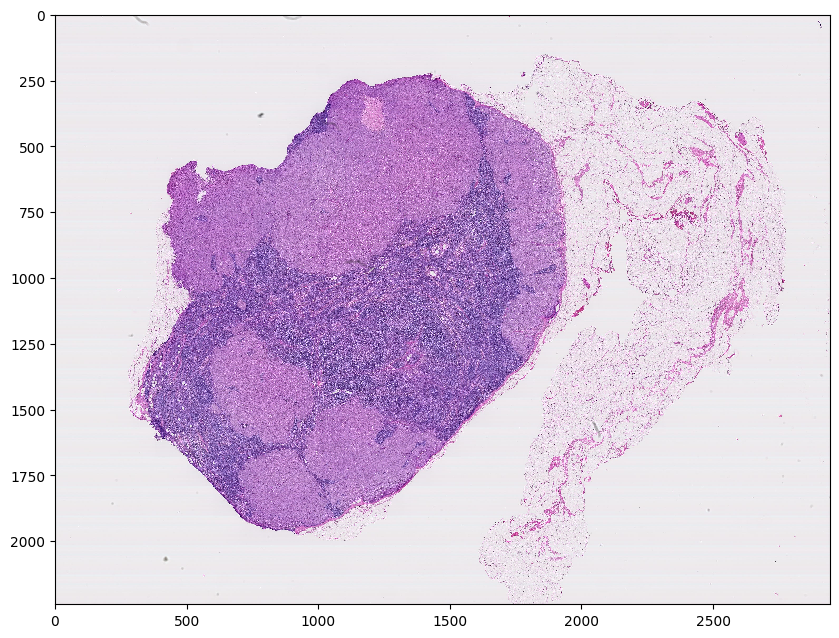

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

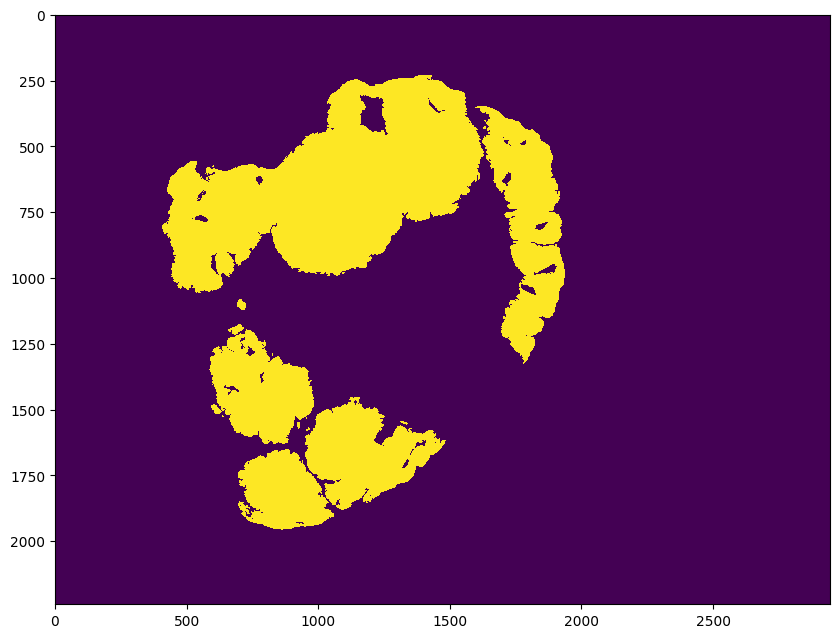

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=tumor_mask.level_dimensions[5][0], 
                        height=tumor_mask.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

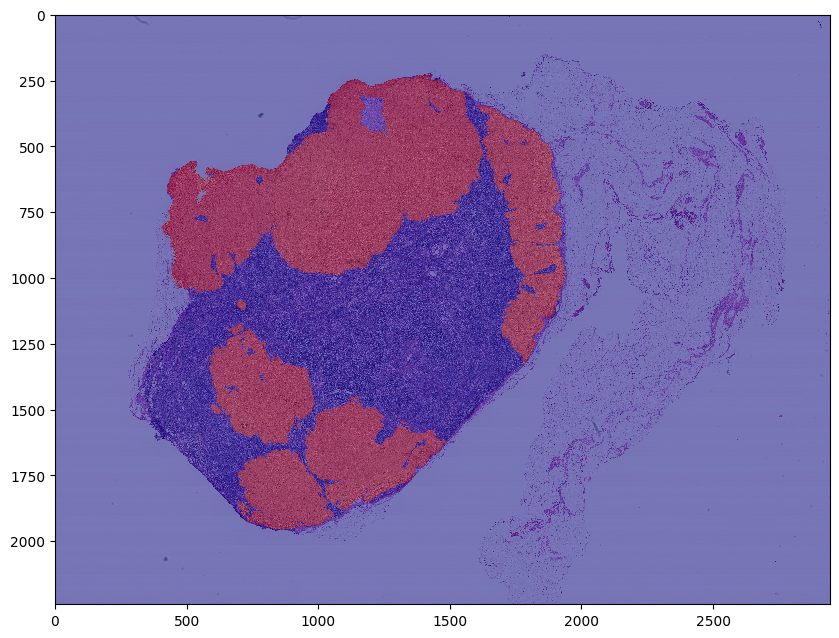

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

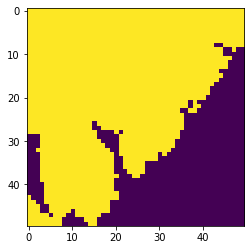

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top left blob in the image above.
region = read_slide(tumor_mask, x=150 * 128, y=200 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)

    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

2129295 tissue_pixels pixels (32.3 percent of the image)


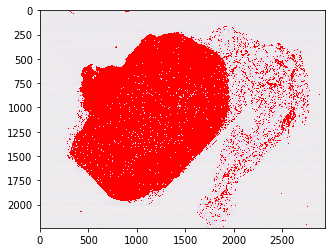

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# Generate training/test dataset

## Extract patches from sliding window

- To avoid memory overload and expedite extraction, only levels `[3, 4]` will be used.
- We will start from the single scale of level 3.

In [0]:
LEVELS = [3, 4]
PATCH_SIZE = 300
STRIDE = 128

In [0]:
def crop_center(img, crop_x=128, crop_y=128):
  """
  Crop the center area for an image.
  """
  y, x, _ = img.shape
  start_x = x // 2 - (crop_x // 2)
  start_y = y // 2 - (crop_y // 2)    
  return img[start_y:start_y + crop_y, start_x:start_x + crop_x, :]

In [0]:
def pad_along_axis(arr, target_length, axis):
  pad_size = int(target_length)
  n_axis = len(arr.shape)

  # if pad_size < 0:
  #   return arr

  n_pad = [(0, 0) for x in range(n_axis)]
  n_pad[axis] = (0, pad_size)

  return np.pad(arr, pad_width=n_pad, mode='constant', constant_values=0)

In [0]:
def _extract_patch(slide_img, max_x, max_y, check, dropped,
                   scale=1, patch_size=PATCH_SIZE, stride=STRIDE):
  """
  Helper function to extract patch at a level.
  """
  max_x_cur = max_x * scale  # Max dim for current level
  max_y_cur = max_y * scale
  # stride *= scale
  half_patch = patch_size // 2
  patches = []

  idx = 0  # used to track dropped patch index
  # Iterate the center of the patch
  for _, y in enumerate(np.arange(half_patch, max_y - half_patch, stride)):
    y *= scale
    for _, x in enumerate(np.arange(half_patch, max_x - half_patch, stride)):
      x *= scale

      if not check:
        if idx in dropped:
          idx += 1
          continue
        else:
          idx += 1

      # Padding will only be executed at higher levels
      # Pad when out of border
      y_top = int(max(0, y - half_patch))
      y_bottom = int(min(max_y_cur, y + half_patch))
      x_left = int(max(0, x - half_patch))
      x_right = int(min(max_x_cur, x + half_patch))
      
      patch = slide_img[y_top : y_bottom, x_left : x_right, :]
      
      if patch.shape[0] != patch_size:
        if y_top == 0:
          patch = pad_along_axis(patch, half_patch - y, 0)
        if y_bottom == max_y_cur:
          patch = pad_along_axis(patch, half_patch - (max_y_cur - y), 0)
      if patch.shape[1] != patch_size:
        if x_left == 0:
          patch = pad_along_axis(patch, half_patch - x, 1)
        if x_right == max_x_cur:
          patch = pad_along_axis(patch, half_patch - (max_x_cur - x), 1)
      
      if check: # if at min level, check and skip non-tissue areas
        tissue_pixels = find_tissue_pixels(patch)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
        if percent_tissue < 40:
          dropped.append(idx)
          idx += 1
          continue
        idx += 1

      assert patch.shape == (PATCH_SIZE, PATCH_SIZE, 3) 
      patches.append(patch)
  
  return patches, dropped

In [0]:
def _extract_patch_labels(mask_img, max_x, max_y, dropped,
                          scale=1, patch_size=PATCH_SIZE, stride=STRIDE):
  """
  Helper function to extract patch labels at a level.
  """
  max_x_cur = max_x * scale  # Max dim for current level
  max_y_cur = max_y * scale
  # stride *= scale
  half_patch = patch_size // 2

  labels = []

  idx = 0  # used to track dropped patch index
  for _, y in enumerate(np.arange(half_patch, max_y - half_patch, stride)):
    y *= scale
    for _, x in enumerate(np.arange(half_patch, max_x - half_patch, stride)):
      x *= scale
      if idx in dropped:
        idx += 1
        continue
      else:
        idx += 1
      
      # Padding will only be executed at higher levels
      # Pad when out of border
      y_top = int(max(0, y - half_patch))
      y_bottom = int(min(max_y, y + half_patch))
      x_left = int(max(0, x - half_patch))
      x_right = int(min(max_x, x + half_patch))
      
      patch = mask_img[y_top : y_bottom, x_left : x_right, :]
      
      if patch.shape[0] != patch_size:
        if y_top == 0:
          patch = pad_along_axis(patch, half_patch - y, 0)
        if y_bottom == max_y_cur:
          patch = pad_along_axis(patch, half_patch - (max_y_cur - y), 0)
      if patch.shape[1] != patch_size:
        if x_left == 0:
          patch = pad_along_axis(patch, half_patch - x, 1)
        if x_right == max_x_cur:
          patch = pad_along_axis(patch, half_patch - (max_x_cur - x), 1)
      
      # Crop the center 128 region to label
      patch = crop_center(patch)  

      lab = 0 if np.all(patch == 0) else 1
      labels.append(lab)
  
  return labels

In [0]:
def extract_patch(slide, tumor_mask, patch_type, levels=LEVELS, 
                  patch_size=PATCH_SIZE, stride=STRIDE):
  """
  Extract patch for a slide for specified levels, patch size and stride.
  """
  MIN_L = min(levels)
  # Max width by the highest level (lowest resolution)
  MAX_X = slide.level_dimensions[MIN_L][0] - patch_size // 2
  # Max height by the highest level (lowest resolution)
  MAX_Y = slide.level_dimensions[MIN_L][1] - patch_size // 2
  MIN_DOWNSAMPLES = slide.level_downsamples[MIN_L]
  
  patches = dict.fromkeys(levels, None)
  labels = dict.fromkeys(levels, None)
  dropped = []  # List to track dropped patch indices at the min level
  for i, j in enumerate(levels):
    # Check non-tissue areas if at min level of a slide in training set
    check = True if i == 0 and patch_type == 'train' else False
    downsamples = slide.level_downsamples[j]
    scale = MIN_DOWNSAMPLES / downsamples # zoom-in scale w.r.t. MIN_L

    # Read slide image at level j
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=j, 
                             width=slide.level_dimensions[j][0], 
                             height=slide.level_dimensions[j][1])
    
    patches[j], dropped = _extract_patch(slide_image, MAX_X, MAX_Y, check, 
                                         dropped, scale, patch_size, stride)
    # Read tumor mask at level j
    mask_image = read_slide(tumor_mask, 
                            x=0, 
                            y=0, 
                            level=j, 
                            width=slide.level_dimensions[j][0], 
                            height=slide.level_dimensions[j][1])
    
    labels[j] = _extract_patch_labels(mask_image, MAX_X, MAX_Y,
                                      dropped, scale, patch_size, stride)
    
    # Check that the number of slide patches matches that of mask labels
    assert len(patches[j]) == len(labels[j])

  return patches, labels

In [0]:
def extract_patch_from_slide(all_slide_paths, all_tumor_mask_paths, patch_type):
  all_patches = {}

  stride = STRIDE if patch_type == 'train' else PATCH_SIZE

  for i in range(len(all_slide_paths)):
    
    slide_path = all_slide_paths[i]
    slide = open_slide(slide_path)

    tumor_mask_path = all_tumor_mask_paths[i]
    tumor_mask = open_slide(tumor_mask_path)

    patches, labels = extract_patch(slide, tumor_mask, 
                                    patch_type=patch_type, stride=stride)

    slide_name = pathlib.Path(slide_path).parts[6].replace('.tif', '')
    print('Extracted patches and labels for slide %s' % slide_name)
    print('Number of patches: ', {k: len(v) for k, v in patches.items()})

    all_patches[slide_name] = {}
    all_patches[slide_name]['patches'] = patches
    all_patches[slide_name]['labels'] = labels

  return all_patches

### Leave out two slides as the test set
- To avoid information leakage, randomly sample slide names so that patches from the same slide will be only in either of train/test set.

In [13]:
all_slide_names = []
for i in range(len(all_slide_paths)):
  all_slide_names.append(pathlib.Path(all_slide_paths[i]).parts[6].replace('.tif', ''))
all_slide_names[:3]

['tumor_001', 'tumor_002', 'tumor_005']

In [14]:
np.random.seed(0)
test_id = list(np.random.choice(all_slide_names, 2))
train_id = list(set(all_slide_names) - set(test_id))

assert len(train_id) == 19
test_id

['tumor_075', 'tumor_084']

In [0]:
train_slide_paths = [p for p in all_slide_paths if any(s in p for s in train_id)]
train_tumor_mask_paths = [p for p in all_tumor_mask_paths if any(s in p for s in train_id)]

test_slide_paths = [p for p in all_slide_paths if any(s in p for s in test_id)]
test_tumor_mask_paths = [p for p in all_tumor_mask_paths if any(s in p for s in test_id)]

### Draw patches
- Draw overlapping patches for the training set (`stride = 128`).
- Draw non-overlapping patches for the test set (`stride = 299`).

In [23]:
all_train_patches = extract_patch_from_slide(train_slide_paths, 
                                             train_tumor_mask_paths,
                                             'train')

Extracted patches and labels for slide tumor_001
Number of patches:  {3: 1601, 4: 1601}
Extracted patches and labels for slide tumor_002
Number of patches:  {3: 702, 4: 702}
Extracted patches and labels for slide tumor_005
Number of patches:  {3: 765, 4: 765}
Extracted patches and labels for slide tumor_012
Number of patches:  {3: 1215, 4: 1215}
Extracted patches and labels for slide tumor_016
Number of patches:  {3: 963, 4: 963}
Extracted patches and labels for slide tumor_019
Number of patches:  {3: 438, 4: 438}
Extracted patches and labels for slide tumor_023
Number of patches:  {3: 818, 4: 818}
Extracted patches and labels for slide tumor_031
Number of patches:  {3: 624, 4: 624}
Extracted patches and labels for slide tumor_035
Number of patches:  {3: 758, 4: 758}
Extracted patches and labels for slide tumor_057
Number of patches:  {3: 619, 4: 619}
Extracted patches and labels for slide tumor_059
Number of patches:  {3: 780, 4: 780}
Extracted patches and labels for slide tumor_064
N

In [111]:
all_test_patches = extract_patch_from_slide(test_slide_paths, 
                                            test_tumor_mask_paths,
                                            'test')

Extracted patches and labels for slide tumor_075
Number of patches:  {3: 1184, 4: 1184}
Extracted patches and labels for slide tumor_084
Number of patches:  {3: 910, 4: 910}


In [0]:
def display_patch(dataset, indices):
  if dataset == 'train':
    df = all_train_patches
    slide_name = 'tumor_101'
  else:
    df = all_test_patches
    slide_name = 'tumor_084'

  fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=100)
  for i in range(len(indices)): 
    for j in range(len(LEVELS)): 
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title('Level: %d, Label: %d'\
                        % (LEVELS[j], \
                            df[slide_name]['labels'][LEVELS[j]][indices[i]]))
      ax[i][j].imshow(df[slide_name]['patches'][LEVELS[j]][indices[i]])

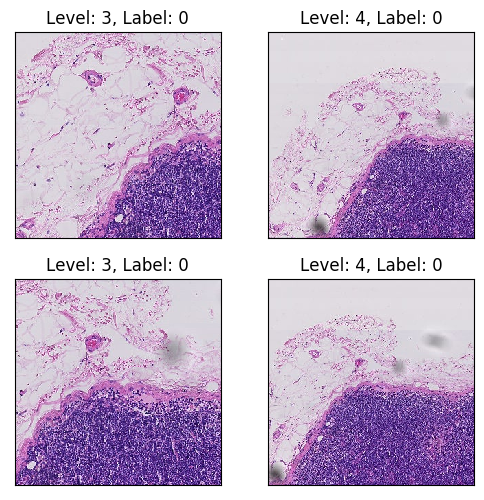

In [0]:
display_patch('train', [0, 1])

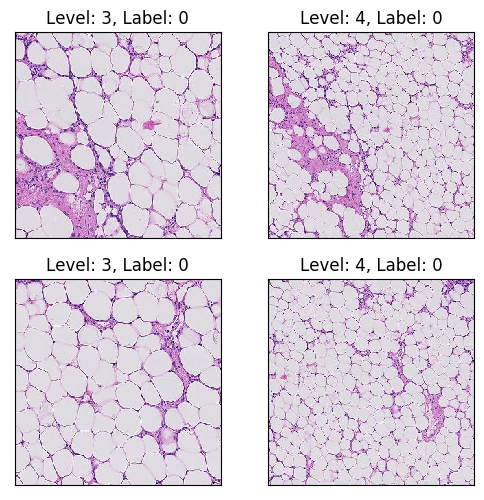

In [0]:
display_patch('test', [251, 252])

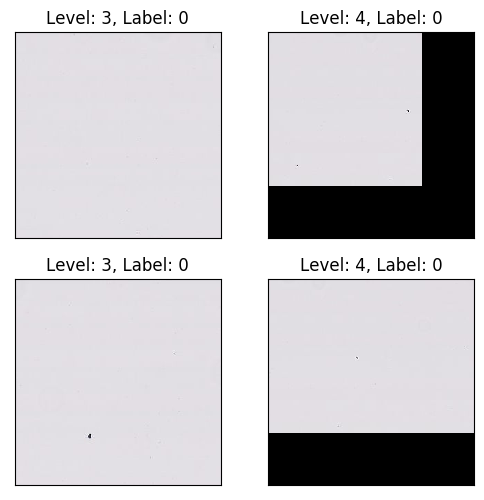

In [0]:
display_patch('test', [0, 1])

### Write out patches to drive
- Run below once
- Free up space once saved

In [0]:
import shutil
# Build a directory for patches
patch_dir = pathlib.Path('/content/drive/My Drive/adl/patches')
train_dir = os.path.join(patch_dir, 'train')
test_dir = os.path.join(patch_dir, 'test')

In [0]:
# Remove directories if exist
if os.path.isdir(patch_dir):
  shutil.rmtree(patch_dir)

os.mkdir(patch_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

In [0]:
# Train directory: train/3/..., train/4/...
for i in LEVELS:
  os.mkdir(os.path.join(train_dir, str(i)))

In [0]:
# Test directory: test/tumor_075/3/..., test/tumor_075/4/...,
for s in test_id:
  tmp = os.path.join(test_dir, s)
  os.mkdir(tmp)
  for i in LEVELS:
    os.mkdir(os.path.join(tmp, str(i)))

In [0]:
"""
all_patches = {
  'tumor_001': {
    'patches': {'3': [(299, 299, 3), ...], '4': [], '5': []}, 
    'labels': {'3': [0, 1, ...], '4': [], '5': []}
  },
  ...
}
"""
# train/3/0/tumor_001_i_label.jpeg
# Save training patches to drive
for k1, v1 in all_train_patches.items():
  for k2, v2 in v1.items():
    if k2 == 'patches':
      for k3, v3 in v2.items():
        for i in range(len(v3)):
          im = Image.fromarray(v3[i])
          # Share the level 3 label with level 4
          label = all_train_patches[k1]['labels'][3][i]
          p = os.path.join(train_dir, str(k3))
          fname = ('_').join([k1, str(i), str(label)]) + '.jpeg'
          im.save(os.path.join(p, fname))

In [0]:
del all_train_patches

In [0]:
"""
all_patches = {
  'tumor_001': {
    'patches': {'3': [(299, 299, 3), ...], '4': [], '5': []}, 
    'labels': {'3': [0, 1, ...], '4': [], '5': []}
  },
  ...
}
"""

# Save test patches to drive
# test/tumor_075/...
for k1, v1 in all_test_patches.items():
  for k2, v2 in v1.items():
    if k2 == 'patches':
      for k3, v3 in v2.items():
        for i in range(len(v3)):
          im = Image.fromarray(v3[i])
          label = all_test_patches[k1]['labels'][k3][i] 
          p = os.path.join(test_dir, k1)
          p = os.path.join(p, str(k3))
          fname = ('_').join([k1, str(i), str(label)]) + '.jpeg'
          im.save(os.path.join(p, fname))

In [0]:
del all_test_patches

# Preprocessing
- Since all patches are ordered and matched across levels, we can simply preprocess all levels using the same pipeline.
- Images in the format: `[slide_name]_[patch_no]_[label].jpeg`
- We will start with **level 3**, then scale up in the later phase.

## Train-test-split

In [0]:
def get_test_paths(test_id):
  all_test_paths = dict.fromkeys(LEVELS, [])
  for i in LEVELS:
    all_test_paths[i] = list(patch_dir.glob('test/' + test_id + '/' + str(i) + '/*'))
    all_test_paths[i] = [str(path) for path in all_test_paths[i]]
  
  print('Slide name:', test_id)
  print('First three rows:\n', all_test_paths[3][:3])
  image_count = len(all_test_paths[3])
  print('Total number of images:', image_count)
  
  return all_test_paths

In [125]:
all_test_paths_075 = get_test_paths(test_id[0])

Slide name: tumor_075
First three rows:
 ['/content/drive/My Drive/adl/patches/test/tumor_075/3/tumor_075_0_0.jpeg', '/content/drive/My Drive/adl/patches/test/tumor_075/3/tumor_075_1_0.jpeg', '/content/drive/My Drive/adl/patches/test/tumor_075/3/tumor_075_2_0.jpeg']
Total number of images: 1184


In [126]:
all_test_paths_084 = get_test_paths(test_id[1])

Slide name: tumor_084
First three rows:
 ['/content/drive/My Drive/adl/patches/test/tumor_084/3/tumor_084_0_0.jpeg', '/content/drive/My Drive/adl/patches/test/tumor_084/3/tumor_084_1_0.jpeg', '/content/drive/My Drive/adl/patches/test/tumor_084/3/tumor_084_2_0.jpeg']
Total number of images: 910


### Sanity check for patch extraction

In [0]:
def get_n_patch(slide_path, tumor_mask_path, level):
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  # number of patches per col
  n_patch_h = slide.level_dimensions[level][0] // PATCH_SIZE
  # number of patches per row
  n_patch_v = slide.level_dimensions[level][1] // PATCH_SIZE 

  return (n_patch_h, n_patch_v)

In [0]:
import matplotlib.image as mpimg

def concat_patches(patch_path, n_patch_h, n_patch_v, level):
  # Convert path into np array
  img = [mpimg.imread(i) for i in patch_path[level]]

  # 1. Stack patches horizontally
  partition = np.array_split(img, n_patch_v)
  rows = [np.hstack(p) for p in partition]
  # 2. Stack rows of patches vertically
  res = np.vstack(rows)

  return res

In [22]:
N_PATCH = dict.fromkeys(test_id, None)
N_PATCH['tumor_075'] = get_n_patch(test_slide_paths[0], test_tumor_mask_paths[0], 3)
N_PATCH['tumor_084'] = get_n_patch(test_slide_paths[1], test_tumor_mask_paths[1], 3)
N_PATCH

{'tumor_075': (37, 32), 'tumor_084': (27, 35)}

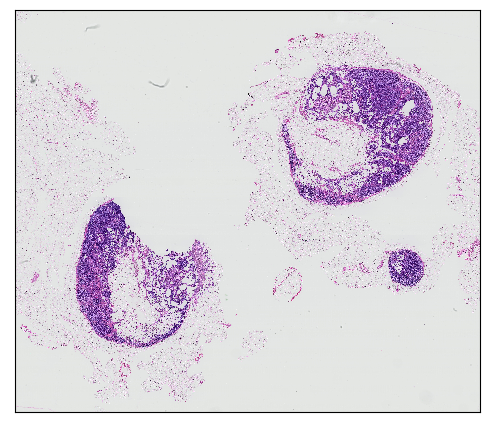

In [0]:
restored_075 = concat_patches(all_test_paths_075[3], 
                              N_PATCH['tumor_075'][0],
                              N_PATCH['tumor_075'][1],
                              3)
plt.figure(figsize=(6, 6), dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(restored_075)
plt.show()

In [0]:
all_train_paths = dict.fromkeys(LEVELS, None)

for i in LEVELS:
  all_train_paths[i] = list(patch_dir.glob('train/' + str(i) + '/*'))
  all_train_paths[i] = [str(path) for path in all_train_paths[i]]

In [24]:
for i in LEVELS:
  print('Training set, level:', i)
  print('First two rows:\n', all_train_paths[i][:2])
  image_count = len(all_train_paths[i])
  print('Total number of images:', image_count)

Training set, level: 3
First two rows:
 ['/content/drive/My Drive/adl/patches/train/3/tumor_001_0_0.jpeg', '/content/drive/My Drive/adl/patches/train/3/tumor_001_1_0.jpeg']
Total number of images: 22343
Training set, level: 4
First two rows:
 ['/content/drive/My Drive/adl/patches/train/4/tumor_001_0_0.jpeg', '/content/drive/My Drive/adl/patches/train/4/tumor_001_1_0.jpeg']
Total number of images: 22343


In [0]:
def get_labels(all_paths):
  all_labels = [int(pathlib.Path(p).parts[-1].strip('.jpeg')[-1]) \
                for p in all_paths]
  return all_labels

In [0]:
all_test_labels_075 = get_labels(all_test_paths_075[3])

In [0]:
all_test_labels_084 = get_labels(all_test_paths_084[3])

In [0]:
all_train_labels = get_labels(all_train_paths[3])

In [0]:
from sklearn.model_selection import train_test_split
all_X_train, all_X_val = dict.fromkeys(LEVELS, []), dict.fromkeys(LEVELS, [])
all_y_train, all_y_val = dict.fromkeys(LEVELS, []), dict.fromkeys(LEVELS, [])

for i in LEVELS:
  all_X_train[i], all_X_val[i], \
  all_y_train[i], all_y_val[i] = train_test_split(all_train_paths[i],
                                                  all_train_labels,
                                                  train_size=0.8,
                                                  random_state=0)

In [45]:
print('Train set size at each level:', len(all_X_train[3]))
print('Validation set size at each level:', len(all_X_val[3]))

Train set size at each level: 17874
Validation set size at each level: 4469


In [0]:
import matplotlib.image as mpimg

def display_image(img_path):
  img = mpimg.imread(img_path)
  plt.figure(figsize=(2, 2), dpi=100)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

Level: 3


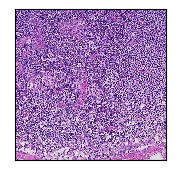

Level: 4


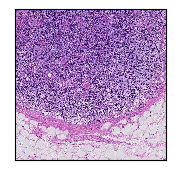

In [0]:
# Sanity check: the orders for patches in all levels after spliting should match
for i in LEVELS: 
  print('Level:', i)
  display_image(all_X_train[i][45])

## Class imbalance
- Tumor patches are rare.
- Treatment: class weights

In [46]:
print('Class 0:', np.bincount(all_y_train[3])[0])
print('Class 1:', np.bincount(all_y_train[3])[1])

Class 0: 14835
Class 1: 3039


In [30]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  [0, 1],
                                                  all_y_train[3])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6024266936299292, 1: 2.9407699901283317}

# Model
- Multi-scale InceptionV3 towers
- 299×299 patch
- For each input patch, predict the label of the center 128×128 region
- Metric
  - ROC-AUC: slide-level classification
  - *FROC: tumor detection and localization. (sensitivity)


## Create a tf.dataset for training, validation, and testing




In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
IMG_SIZE = 299

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
  return img

In [0]:
def create_dataset(X, y, ds_type):
  path_ds = tf.data.Dataset.from_tensor_slices(X)
  image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, tf.int32))
  dataset = tf.data.Dataset.zip((image_ds, label_ds))

  # Batch
  if ds_type == 'train': # Shuffle for training
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  else:
    dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=AUTOTUNE)
  return dataset

In [0]:
all_train_ds = create_dataset(all_X_train[3], all_y_train[3], 'train')
all_val_ds = create_dataset(all_X_val[3], all_y_val[3], 'train')
all_test_ds_075 = create_dataset(all_test_paths_075[3], 
                                 all_test_labels_075, 'test')
all_test_ds_084 = create_dataset(all_test_paths_084[3], 
                                 all_test_labels_084, 'test')

In [0]:
# Sanity check
print('Two batches data:')
for img, label in all_train_ds.take(2):
  print(img.shape, label.numpy())

Two batches data:
(32, 299, 299, 3) [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0]
(32, 299, 299, 3) [1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0]


## One scale (level 3), simple CNN

In [0]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

In [0]:
def make_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', 
                   input_shape=(299, 299, 3)))
  model.add(MaxPooling2D()) 

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D())  

  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D())

  model.add(Dropout(0.5))

  model.add(Flatten())

  # Binary classifier
  model.add(Dense(1, activation='sigmoid'))

  return model

In [0]:
m1 = make_model()
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0

In [0]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

In [0]:
m1.compile(optimizer='adam', 
           loss='binary_crossentropy',
           metrics=[AUC()])

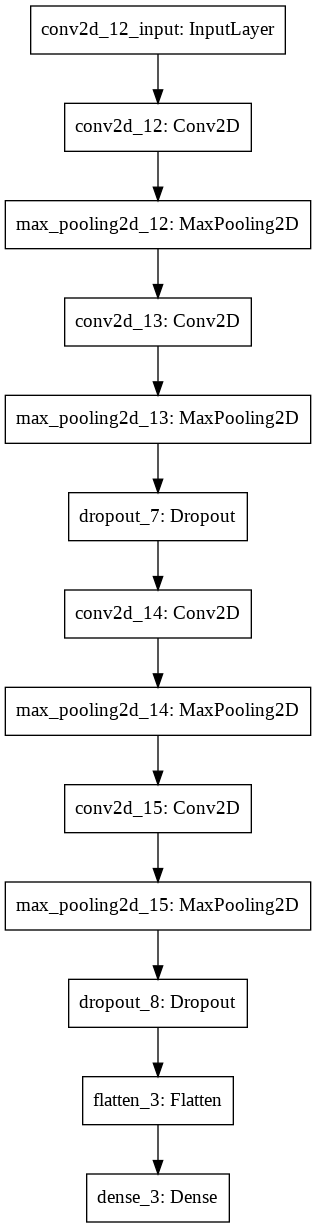

In [0]:
plot_model(m1, to_file='m1.png')

In [0]:
# Run ONCE before fitting (for plotting purpose)
cnt = 0

In [0]:
history1 = m1.fit(
    all_train_ds,
    validation_data=all_val_ds,
    class_weight=class_weights,
    epochs=5)

Train for 559 steps, validate for 140 steps
Epoch 1/5
559/559 [==============================] - 85s 152ms/step - loss: 0.4555 - auc: 0.8664 - val_loss: 0.4359 - val_auc: 0.9126
Epoch 2/5
559/559 [==============================] - 69s 124ms/step - loss: 0.3335 - auc: 0.9290 - val_loss: 0.3498 - val_auc: 0.9517
Epoch 3/5
559/559 [==============================] - 70s 125ms/step - loss: 0.2793 - auc: 0.9492 - val_loss: 0.3005 - val_auc: 0.9446
Epoch 4/5
559/559 [==============================] - 70s 125ms/step - loss: 0.2524 - auc: 0.9578 - val_loss: 0.2398 - val_auc: 0.9638
Epoch 5/5
559/559 [==============================] - 69s 123ms/step - loss: 0.2322 - auc: 0.9650 - val_loss: 0.2263 - val_auc: 0.9762


In [0]:
# Save the model
m1.save('/content/m1.h5')

In [0]:
from google.colab import files

In [0]:
files.download('/content/m1.h5')

In [0]:
files.download('/content/m1.png')

In [0]:
def plot_history(history, cnt):
  
  auc_name = 'auc'
  if cnt - 1 != 0:
    auc_name = 'auc_' + str(cnt - 1)
  val_auc_name = 'val_' + auc_name

  auc = history.history[auc_name]
  val_auc = history.history[val_auc_name]
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(auc))

  plt.title('Training and validation AUC')
  plt.plot(epochs, auc, color='blue', label='Train')
  plt.plot(epochs, val_auc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [0]:
cnt += 1

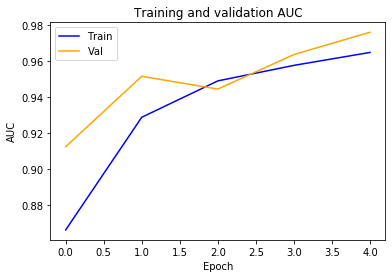

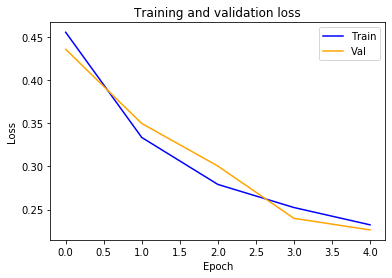

In [0]:
plot_history(history1, cnt)

### Prediction

- Find the probability of each instance belonging to class 1, i.e., tumor.

In [0]:
pred1_075 = m1.predict(all_test_ds_075)

In [0]:
pred1_084 = m1.predict(all_test_ds_084)

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compare_pred(test_slide_paths, test_tumor_mask_paths, slide_name, 
                 prediction, level=3):
  slide= open_slide(test_slide_paths)
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  del slide
  tumor_mask = open_slide(test_tumor_mask_paths)
  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=level, 
                          width=tumor_mask.level_dimensions[level][0], 
                          height=tumor_mask.level_dimensions[level][1])
  mask_image = mask_image[:,:,0]
  del tumor_mask

  prediction = np.array_split(prediction.flatten() * 255, N_PATCH[slide_name][1])
  fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=100)

  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[0].set_title('Ground Truth')
  ax[0].imshow(slide_image)
  ax[0].imshow(mask_image, cmap='jet', alpha=0.5)
  # ax[0].imshow(mask_image)

  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[1].set_title('Prediction')
  # im = ax[1].imshow(slide_image)
  # im = ax[1].imshow(prediction, cmap='jet', alpha=0.4)
  im = ax[1].imshow(prediction)
  divider = make_axes_locatable(ax[1])
  cax = divider.append_axes('right', size='5%', pad=0.06)
  plt.colorbar(im, cax=cax)
  # plt.colorbar(im, ax=ax[1], fraction=0.05, pad=0.05)
  plt.show()

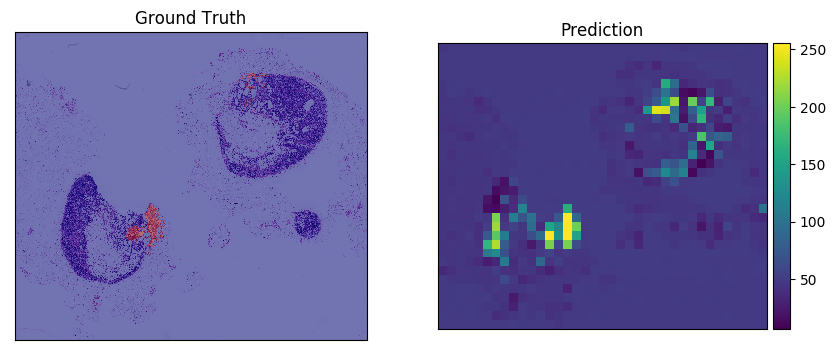

In [0]:
compare_pred(test_slide_paths[0], test_tumor_mask_paths[0], 'tumor_075', pred1_075)

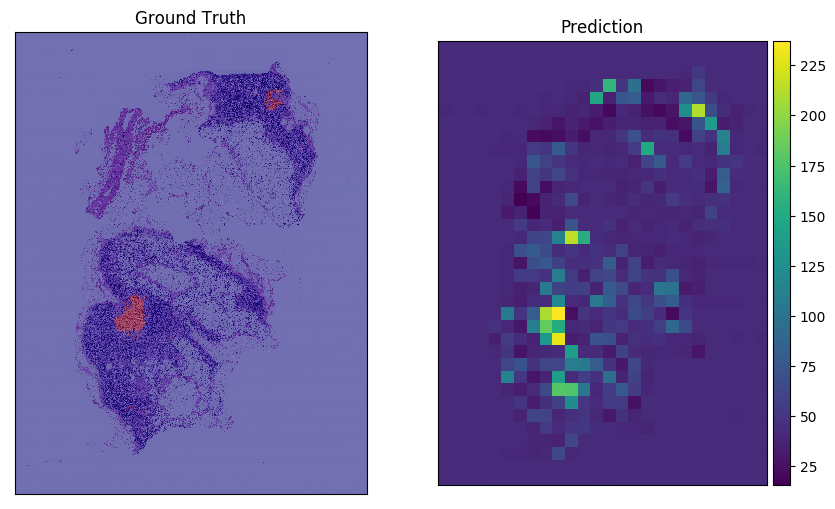

In [0]:
compare_pred(test_slide_paths[1], test_tumor_mask_paths[1], 'tumor_084', pred1_084)

## One scale, InceptionV3

### Data Augmentation

In [0]:
# def path_to_array(path):
#   img = Image.open(path)
#   img = np.array(img)
#   return img

In [0]:
# X_train_arr = np.array([path_to_array(p) for p in all_X_train[3]])

In [0]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale= 1./255,
#                                    rotation_range=10,
#                                    horizontal_flip=True)

# train_generator = train_datagen.flow(
#     X_train_arr,
#     all_y_train[3],
#     batch_size=16)

In [0]:
# X_val_arr = np.array([path_to_array(p) for p in all_X_val[3]]) 

In [0]:
# X_val_arr = X_val_arr / 255.0

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

def make_model_inception():
  model = Sequential()
  base_model = InceptionV3(include_top=False, 
                           weights='imagenet',
                           input_shape=(299, 299, 3))
  
  # Do not update the pretrained weights during training
  base_model.trainable = False 
  
  model.add(base_model)
  model.add(GlobalAveragePooling2D())

  # model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))

  # Binary classifier
  model.add(Dense(1, activation='sigmoid'))

  return model

In [192]:
m2 = make_model_inception()
m2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


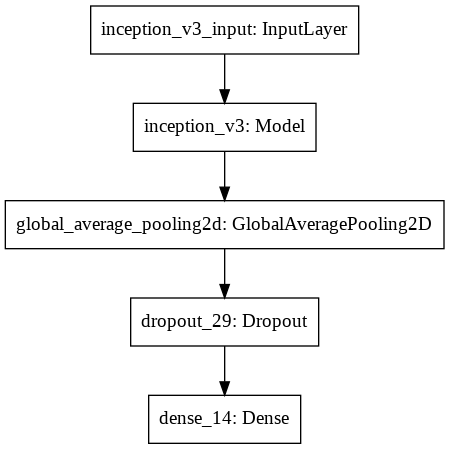

In [180]:
plot_model(m2, to_file='/content/m2.png')

In [0]:
files.download('/content/m2.png')

In [0]:
from tensorflow.keras.optimizers import RMSprop

In [0]:
m2.compile(optimizer=RMSprop(lr=2e-5), 
           loss='binary_crossentropy',
           metrics=[AUC()])

In [0]:
cnt2 = 0

In [194]:
history2 = m2.fit(
    all_train_ds,
    validation_data=all_val_ds,
    class_weight=class_weights,
    epochs=15)

Train for 559 steps, validate for 140 steps
Epoch 1/15
559/559 [==============================] - 100s 179ms/step - loss: 0.7197 - auc_9: 0.5348 - val_loss: 0.7478 - val_auc_9: 0.4359
Epoch 2/15
559/559 [==============================] - 95s 169ms/step - loss: 0.6698 - auc_9: 0.6317 - val_loss: 0.7083 - val_auc_9: 0.5439
Epoch 3/15
559/559 [==============================] - 94s 168ms/step - loss: 0.6322 - auc_9: 0.6988 - val_loss: 0.6759 - val_auc_9: 0.6216
Epoch 4/15
559/559 [==============================] - 94s 168ms/step - loss: 0.5972 - auc_9: 0.7516 - val_loss: 0.6519 - val_auc_9: 0.6715
Epoch 5/15
559/559 [==============================] - 94s 168ms/step - loss: 0.5805 - auc_9: 0.7706 - val_loss: 0.6357 - val_auc_9: 0.6998
Epoch 6/15
559/559 [==============================] - 95s 169ms/step - loss: 0.5639 - auc_9: 0.7868 - val_loss: 0.6245 - val_auc_9: 0.7200
Epoch 7/15
559/559 [==============================] - 94s 168ms/step - loss: 0.5400 - auc_9: 0.8134 - val_loss: 0.6175 - 

In [0]:
cnt2 += 1

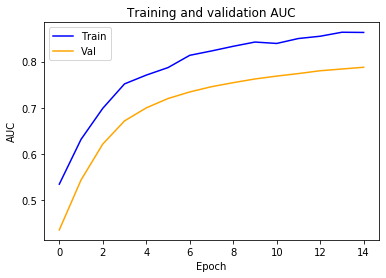

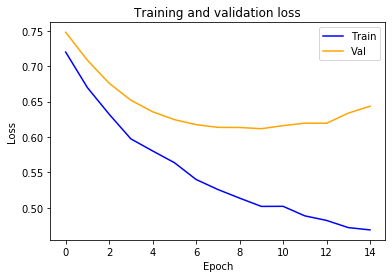

In [209]:
plot_history(history2, cnt2)

In [0]:
pred2_075 = m2.predict(all_test_ds_075)

In [0]:
pred2_084 = m2.predict(all_test_ds_084)

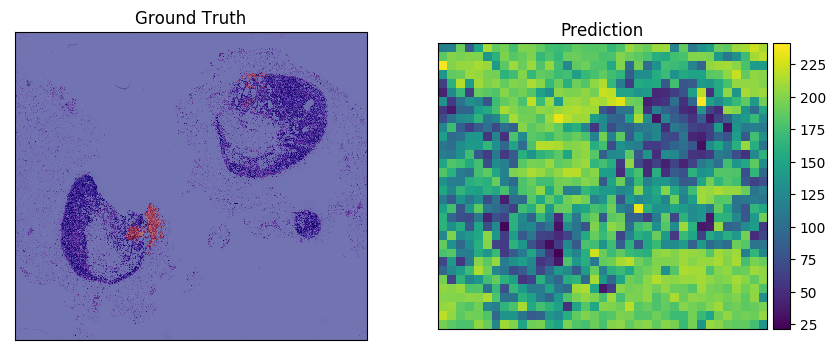

In [212]:
compare_pred(test_slide_paths[0], test_tumor_mask_paths[0], 'tumor_075', pred2_075)

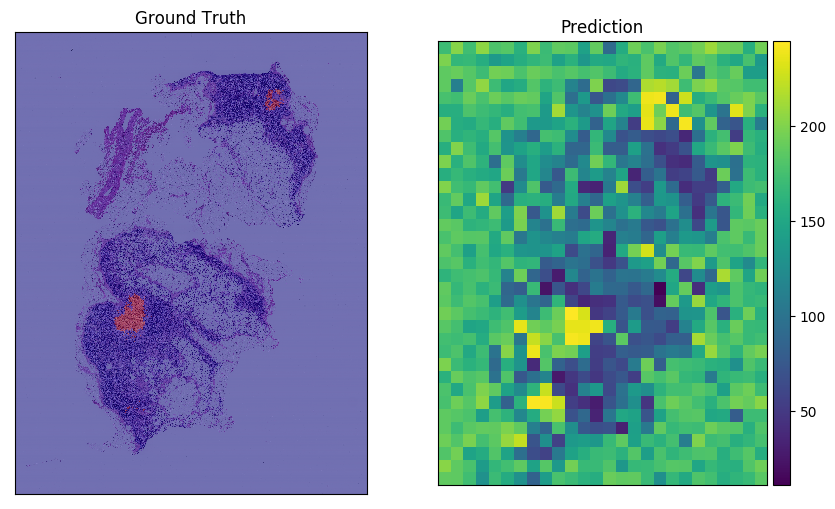

In [213]:
compare_pred(test_slide_paths[1], test_tumor_mask_paths[1], 'tumor_084', pred2_084)

## Multiscale, Simple CNN

In [0]:
def create_dataset_multi(X1, X2, y, ds_type):
  path_ds_1 = tf.data.Dataset.from_tensor_slices(X1)
  path_ds_2 = tf.data.Dataset.from_tensor_slices(X2)
  image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(np.array(y).reshape((-1,1)), tf.int32))

  inputs = tf.data.Dataset.zip((image_ds_1, image_ds_2))
  
  dataset = tf.data.Dataset.zip((inputs, label_ds))
  
  if ds_type == 'train': # Shuffle for training
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  else:
    dataset = dataset.batch(BATCH_SIZE)

  dataset = dataset.prefetch(buffer_size=AUTOTUNE)

  return dataset

In [0]:
all_train_ds_multi = create_dataset_multi(all_X_train[3], all_X_train[4], 
                                          all_y_train[3], 'train')

In [0]:
all_val_ds_multi = create_dataset_multi(all_X_val[3], all_X_val[4], 
                                        all_y_val[3], 'train')

In [0]:
all_test_ds_075_multi = create_dataset_multi(all_test_paths_075[3], 
                                             all_test_paths_075[4], 
                                             all_test_labels_075, 'test')

In [0]:
all_test_ds_084_multi = create_dataset_multi(all_test_paths_084[3], 
                                             all_test_paths_084[4], 
                                             all_test_labels_084, 'test')

In [0]:
from tensorflow.keras.layers import Input, concatenate

def make_model_multi():
  input1 = Input(shape=(299, 299, 3))
  input2 = Input(shape=(299, 299, 3))
 
  # The first branch operates on the first input: level 3
  x = Conv2D(32, (3, 3), activation='relu')(input1)
  x = MaxPooling2D()(x)
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.5)(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.5)(x)
  x = Flatten()(x)

  x = Model(inputs=input1, outputs=x)
 
  # The second branch opreates on the second input: level 4
  y = Conv2D(32, (3, 3), activation='relu')(input2)
  y = MaxPooling2D()(y)
  y = Conv2D(32, (3, 3), activation='relu')(y)
  y = MaxPooling2D()(y)
  y = Dropout(0.5)(y)

  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D()(y)
  y = Conv2D(64, (3, 3), activation='relu')(y)
  y = MaxPooling2D()(y)
  y = Dropout(0.5)(y)
  y = Flatten()(y)

  y = Model(inputs=input2, outputs=y)
 
  # Combine the output of the two branches
  combined = concatenate([x.output, y.output])
 
  # Apply a FC layer and then a binary classifier
  z = Dense(2, activation='relu')(combined)

  z = Dense(1, activation='sigmoid')(z)
  
  model = Model(inputs=[x.input, y.input], outputs=z)

  return model

In [135]:
m3 = make_model_multi()
m3.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 297, 297, 32) 896         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 297, 297, 32) 896         input_14[0][0]                   
___________________________________________________________________________________________

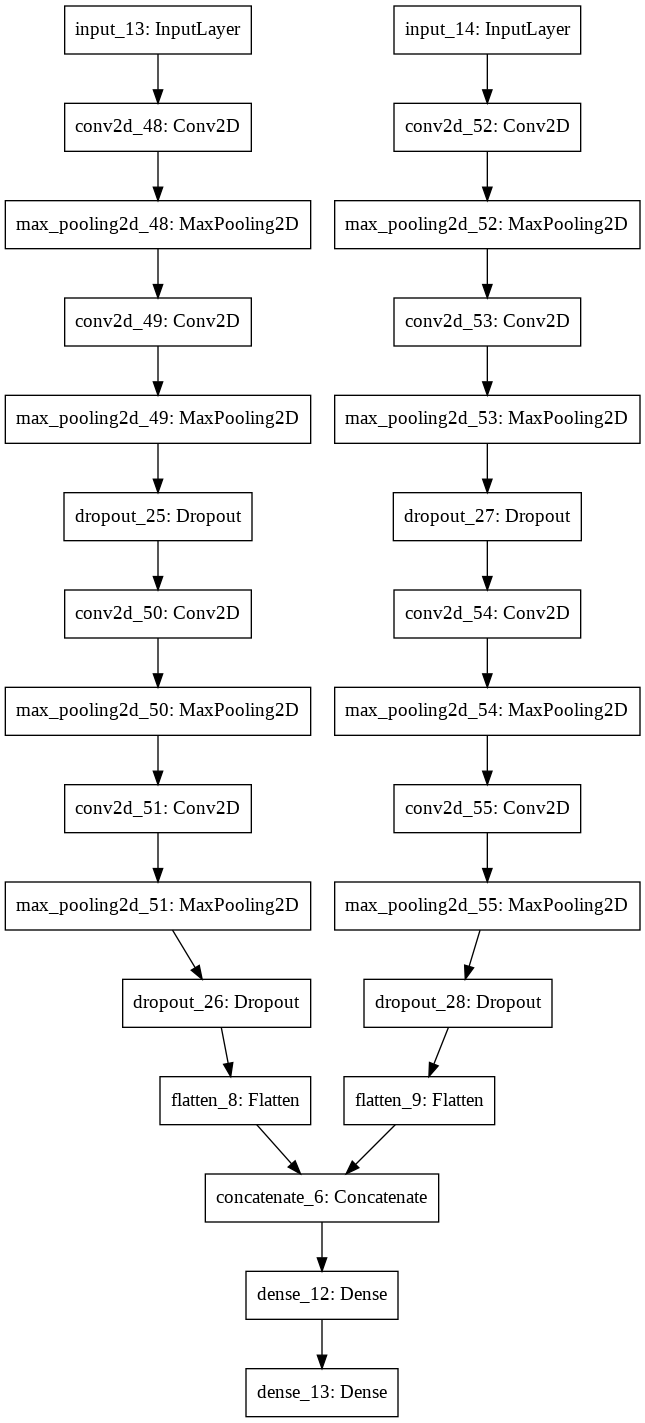

In [137]:
plot_model(m3, to_file='/content/m3.png')

In [0]:
files.download('/content/m3.png')

In [0]:
m3.compile(optimizer=RMSprop(1e-5), 
           loss='binary_crossentropy',
           metrics=[AUC()])

In [0]:
cnt3 = 0

In [142]:
history3 = m3.fit(
    all_train_ds_multi,
    validation_data=all_val_ds_multi,
    class_weight=class_weights,
    epochs=10)

Train for 559 steps, validate for 140 steps
Epoch 1/10
559/559 [==============================] - 170s 303ms/step - loss: 0.6929 - auc_6: 0.5195 - val_loss: 0.6928 - val_auc_6: 0.7159
Epoch 2/10
559/559 [==============================] - 166s 296ms/step - loss: 0.6833 - auc_6: 0.6287 - val_loss: 0.6794 - val_auc_6: 0.7985
Epoch 3/10
559/559 [==============================] - 165s 295ms/step - loss: 0.6520 - auc_6: 0.7693 - val_loss: 0.6507 - val_auc_6: 0.8266
Epoch 4/10
559/559 [==============================] - 164s 294ms/step - loss: 0.6224 - auc_6: 0.8220 - val_loss: 0.6311 - val_auc_6: 0.8419
Epoch 5/10
559/559 [==============================] - 165s 296ms/step - loss: 0.6085 - auc_6: 0.8395 - val_loss: 0.6198 - val_auc_6: 0.8405
Epoch 6/10
559/559 [==============================] - 170s 305ms/step - loss: 0.5976 - auc_6: 0.8480 - val_loss: 0.6115 - val_auc_6: 0.8335
Epoch 7/10
559/559 [==============================] - 170s 303ms/step - loss: 0.5871 - auc_6: 0.8536 - val_loss: 0.6

In [0]:
cnt3 += 1

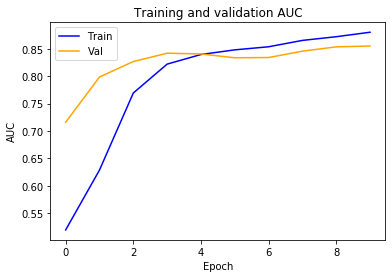

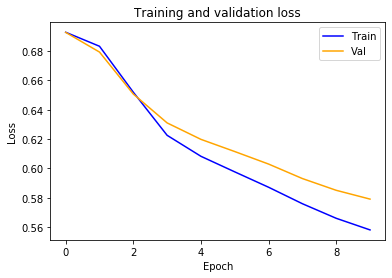

In [153]:
plot_history(history3, cnt3)

In [0]:
pred3_075 = m3.predict(all_test_ds_075_multi)

In [0]:
pred3_084 = m3.predict(all_test_ds_084_multi)

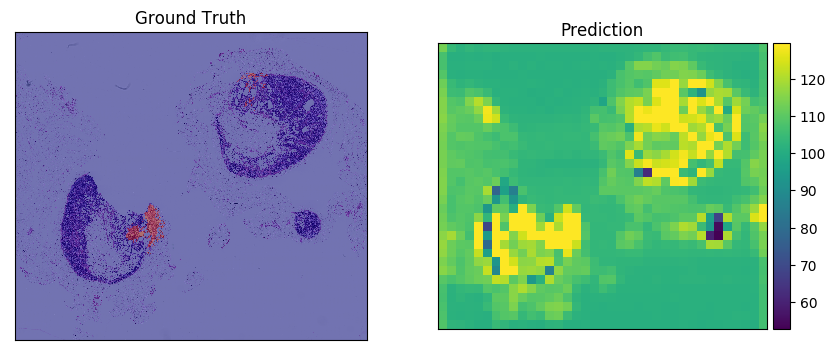

In [172]:
compare_pred(test_slide_paths[0], test_tumor_mask_paths[0], 'tumor_075', pred3_075)

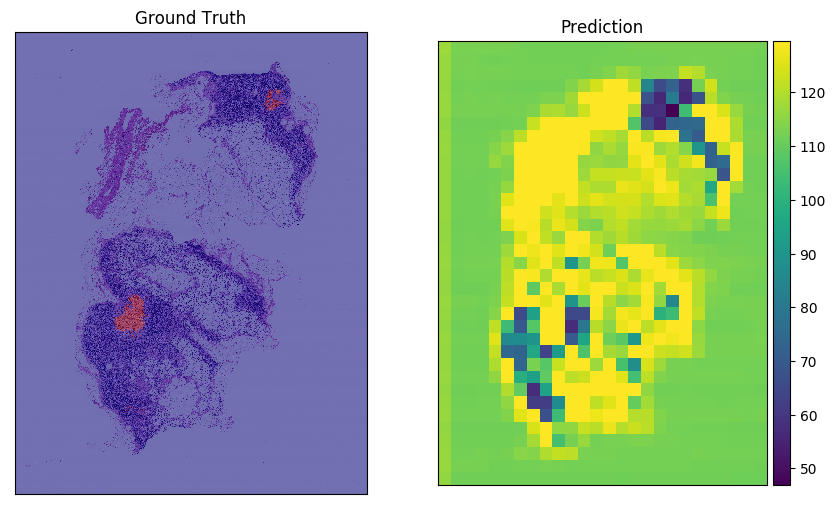

In [175]:
compare_pred(test_slide_paths[1], test_tumor_mask_paths[1], 'tumor_084', pred3_084)